In [652]:
import os
import numpy as np
import rasterio
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# For augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [654]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [656]:
# Data loading and preprocessing
def normalize_data(images):
    for i in range(images.shape[1]):
        band = images[:, i, :, :]
        min_val = np.min(band)
        max_val = np.max(band)
        images[:, i, :, :] = (band - min_val) / (max_val - min_val)
    return images

def load_data(images_dir, labels_dir):
    images = []
    labels = []
    for i in tqdm(range(306), desc="Loading data"):
        img_path = os.path.join(images_dir, f"{i}.tif")
        label_path = os.path.join(labels_dir, f"{i}.png")
        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)
        label = np.array(Image.open(label_path)).astype(np.float32)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

In [658]:
# Augmentation
def get_training_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45,p=0.5),
        A.OneOf([A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=None, p=0.5),
            A.GridDistortion(p=0.5),], p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ])

In [660]:
# Dataset
class WaterSegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
        self.aug = get_training_augmentation() if augment else None

    def __getitem__(self, idx):
        image = self.images[idx].transpose(1, 2, 0)
        mask = self.masks[idx]

        if self.augment:
            sample = self.aug(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        mask = torch.from_numpy(mask).float().unsqueeze(0)

        return image, mask
    def __len__(self):
        return len(self.images)

In [662]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet50_Weights

# Load the pretrained DeepLabV3 model with the new weights system
model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)

# Adjusting the first convolutional layer to accept 12-channel input
first_conv_layer = model.backbone.conv1
model.backbone.conv1 = nn.Conv2d(12, first_conv_layer.out_channels,
                                 kernel_size=first_conv_layer.kernel_size,
                                 stride=first_conv_layer.stride,
                                 padding=first_conv_layer.padding,
                                 bias=first_conv_layer.bias)

# Initialize the weights for the additional channels
with torch.no_grad():
    # Repeat the weights of the first three channels to fill all 12 channels
    first_conv_layer_weights_repeated = torch.repeat_interleave(first_conv_layer.weight, 4, dim=1)  # Repeat weights
    model.backbone.conv1.weight[:, :12] = first_conv_layer_weights_repeated[:, :12]  # Assign the repeated weights
class EnhancedCustomDecoder(nn.Module):
    def __init__(self, in_channels):
        super(EnhancedCustomDecoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)

        self.dropout = nn.Dropout(0.5)  # Dropout added

        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)

        self.final_conv = nn.Conv2d(128, 1, kernel_size=1)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Applying dropout
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.final_conv(x)
        return x

# Update the model's decoder
model.classifier = EnhancedCustomDecoder(2048)

# Consider unfreezing more layers if underfitting persists
# Adjust the number of layers unfrozen as needed based on performance and dataset
for name, param in model.backbone.named_parameters():
    if 'layer3' in name or 'layer4' in name:
        param.requires_grad = True

# Re-initialize optimizer if you unfreeze more layers since it affects which parameters are updated
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

model.to(device)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [663]:
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        focal = self.focal_loss(inputs, targets)
        return dice + focal

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = self.alpha * (1-BCE_EXP)**self.gamma * BCE
        return focal_loss.mean()
# Metrics
def iou_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    targets = targets.float()
    intersection = (preds * targets).sum((1, 2))
    union = (preds + targets).sum((1, 2)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    intersection = (preds * targets).sum((1, 2))
    union = preds.sum((1, 2)) + targets.sum((1, 2))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean().item()

In [664]:
def post_process(pred_mask, threshold=0.5, min_size=100):
    # Ensure the mask is a binary mask
    pred_mask = (pred_mask > threshold).astype(np.uint8)
    
    # Ensure pred_mask is single-channel, which should be the case after thresholding
    # Check if pred_mask has an extra dimension and squeeze if necessary
    if pred_mask.ndim > 2 and pred_mask.shape[0] == 1:
        pred_mask = pred_mask.squeeze(0)
    
    # Use connected components
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(pred_mask, connectivity=8)
    sizes = stats[1:, -1]  # the size of each component
    nb_components = nb_components - 1
    
    # Filter small components
    img2 = np.zeros((output.shape), dtype=np.uint8)
    for i in range(nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 1

    # Optional: perform morphological closing to fill small holes inside the foreground
    img2 = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    return img2


In [665]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_iou = 0.0
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    train_accuracies, val_accuracies = [], []
    train_dice, val_dice = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_acc = 0.0
        train_dc = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            # Extract the main output from the model's output dictionary
            main_output = outputs['out']  # Use 'out' as the key for the main output
            loss = criterion(main_output, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            # Use main_output for calculating metrics
            train_iou += iou_score(main_output, masks)
            train_acc += ((torch.sigmoid(main_output) > 0.5) == masks).float().mean().item()
            train_dc += dice_coefficient(main_output, masks)
        
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_acc /= len(train_loader)
        train_dc /= len(train_loader)
        
        val_loss, val_iou, val_acc, val_dc = validate_model(model, val_loader, criterion, device)
        
        scheduler.step()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_dice.append(train_dc)
        val_dice.append(val_dc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Acc: {train_acc:.4f}, Train Dice: {train_dc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Acc: {val_acc:.4f}, Val Dice: {val_dc:.4f}")
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
    
    return train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies, train_dice, val_dice

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_accuracy = 0.0
    val_dice = 0.0
    num_batches = len(val_loader)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Use the correct output key here as well
            main_output = outputs['out']
            loss = criterion(main_output, masks)
            val_loss += loss.item()
            val_iou += iou_score(main_output, masks)
            val_dice += dice_coefficient(main_output, masks)
            preds = (torch.sigmoid(main_output) > 0.5).float()
            val_accuracy += (preds == masks).float().mean().item()
    val_loss /= num_batches
    val_iou /= num_batches
    val_accuracy /= num_batches
    val_dice /= num_batches
    return val_loss, val_iou, val_accuracy, val_dice

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_accuracy = 0.0
    val_dice = 0.0
    num_batches = len(val_loader)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Extract the main output from the model's output dictionary
            main_output = outputs['out']  # Assuming 'out' is the key for the main output
            loss = criterion(main_output, masks)
            val_loss += loss.item()
            val_iou += iou_score(main_output, masks)
            val_dice += dice_coefficient(main_output, masks)
            preds = (torch.sigmoid(main_output) > 0.5).float()
            val_accuracy += (preds == masks).float().mean().item()

    val_loss /= num_batches
    val_iou /= num_batches
    val_accuracy /= num_batches
    val_dice /= num_batches
    return val_loss, val_iou, val_accuracy, val_dice
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    test_iou = 0.0
    test_dice = 0.0
    num_batches = len(test_loader)
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            main_output = outputs['out']  # Extract main output
            preds = torch.sigmoid(main_output).cpu().numpy()
            
            # Process each prediction to match the shape of masks
            preds = np.array([post_process(pred.squeeze()) for pred in preds])
            
            all_preds.append(preds)
            all_targets.append(masks.cpu().numpy())
            test_iou += iou_score(main_output, masks)
            test_dice += dice_coefficient(main_output, masks)

    # Concatenate lists of arrays along the first axis
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Flatten arrays for accuracy and metric calculations
    accuracy = np.mean(all_preds.flatten() == all_targets.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten(), zero_division=0)
    recall = recall_score(all_targets.flatten(), all_preds.flatten(), zero_division=0)
    f1 = f1_score(all_targets.flatten(), all_preds.flatten(), zero_division=0)
    
    test_iou /= num_batches
    test_dice /= num_batches
    
    return accuracy, test_iou, test_dice, precision, recall, f1



In [666]:
# Visualization functions
def plot_metrics(train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies, train_dice, val_dice):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(20, 5))
    
    plt.subplot(141)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(142)
    plt.plot(epochs, train_ious, 'b-', label='Training IoU')
    plt.plot(epochs, val_ious, 'r-', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.subplot(143)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(144)
    plt.plot(epochs, train_dice, 'b-', label='Training Dice')
    plt.plot(epochs, val_dice, 'r-', label='Validation Dice')
    plt.title('Training and Validation Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    for idx in indices:
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(image)
            main_output = outputs['out']  # Extract the main output
            pred = torch.sigmoid(main_output) > 0.5  # Apply sigmoid and threshold
        
        image = image.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()
        pred = pred.squeeze().cpu().numpy()  # Ensure prediction is correctly squeezed

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(np.transpose(image[:3], (1, 2, 0)))  # Display first 3 bands as RGB if possible
        axes[1].imshow(mask, cmap='gray')
        axes[2].imshow(pred, cmap='gray')
        
        axes[0].set_title('Input Image (First 3 bands)')
        axes[1].set_title('True Mask')
        axes[2].set_title('Predicted Mask')
        
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()


In [667]:
# Load and preprocess data
images_dir = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\images"
labels_dir = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\labels"
    
X, y = load_data(images_dir, labels_dir)
X_normalized = normalize_data(X)


Loading data:   0%|                                                                            | 0/306 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Loading data: 100%|██████████████████████████████████████████████████████████████████| 306/306 [00:05<00:00, 57.88it/s]


In [668]:
 # Split the data
X_trainval, X_test, y_trainval, y_test = train_test_split(X_normalized, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# Create datasets and dataloaders
train_dataset = WaterSegmentationDataset(X_train, y_train, augment=False)
val_dataset = WaterSegmentationDataset(X_val, y_val)
test_dataset = WaterSegmentationDataset(X_test, y_test)

In [669]:
X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_test.shape,y_val.shape

((233, 12, 128, 128),
 (42, 12, 128, 128),
 (31, 12, 128, 128),
 (233, 128, 128),
 (31, 128, 128),
 (42, 128, 128))

In [675]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [676]:
 # Initialize model, loss, optimizer, and scheduler
criterion = CombinedLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

In [677]:
# Train the model
train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies, train_dice, val_dice = train_model(
model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=75, device=device
)


Epoch 1/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 1/75
Train Loss: 0.6873, Train IoU: 0.4941, Train Acc: 0.7771, Train Dice: 0.2854
Val Loss: 87.1086, Val IoU: 0.4147, Val Acc: 0.5586, Val Dice: 0.2966


Epoch 2/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch 2/75
Train Loss: 0.5806, Train IoU: 0.5880, Train Acc: 0.8464, Train Dice: 0.3026
Val Loss: 1.2624, Val IoU: 0.6818, Val Acc: 0.8656, Val Dice: 0.3014


Epoch 3/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 3/75
Train Loss: 0.5341, Train IoU: 0.6160, Train Acc: 0.8584, Train Dice: 0.3170
Val Loss: 0.4519, Val IoU: 0.6933, Val Acc: 0.8725, Val Dice: 0.3064


Epoch 4/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.08it/s]


Epoch 4/75
Train Loss: 0.4410, Train IoU: 0.6226, Train Acc: 0.8661, Train Dice: 0.3459
Val Loss: 0.4104, Val IoU: 0.6890, Val Acc: 0.8659, Val Dice: 0.3155


Epoch 5/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Epoch 5/75
Train Loss: 0.3920, Train IoU: 0.6500, Train Acc: 0.8757, Train Dice: 0.3546
Val Loss: 0.3767, Val IoU: 0.7328, Val Acc: 0.9082, Val Dice: 0.3123


Epoch 6/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.51it/s]


Epoch 6/75
Train Loss: 0.4190, Train IoU: 0.6562, Train Acc: 0.8738, Train Dice: 0.3556
Val Loss: 0.3399, Val IoU: 0.7261, Val Acc: 0.9055, Val Dice: 0.3227


Epoch 7/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.55it/s]


Epoch 7/75
Train Loss: 0.3688, Train IoU: 0.6670, Train Acc: 0.8904, Train Dice: 0.3668
Val Loss: 0.3318, Val IoU: 0.7410, Val Acc: 0.9134, Val Dice: 0.3318


Epoch 8/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.35it/s]


Epoch 8/75
Train Loss: 0.3376, Train IoU: 0.6947, Train Acc: 0.8964, Train Dice: 0.3856
Val Loss: 0.3205, Val IoU: 0.7539, Val Acc: 0.9270, Val Dice: 0.3286


Epoch 9/75: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 9/75
Train Loss: 0.3343, Train IoU: 0.6951, Train Acc: 0.8994, Train Dice: 0.3793
Val Loss: 0.3152, Val IoU: 0.7439, Val Acc: 0.9252, Val Dice: 0.3332


Epoch 10/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.29it/s]


Epoch 10/75
Train Loss: 0.3419, Train IoU: 0.6923, Train Acc: 0.8965, Train Dice: 0.3849
Val Loss: 0.3126, Val IoU: 0.7429, Val Acc: 0.9199, Val Dice: 0.3366


Epoch 11/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 11/75
Train Loss: 0.3231, Train IoU: 0.6992, Train Acc: 0.9035, Train Dice: 0.3866
Val Loss: 0.3265, Val IoU: 0.7385, Val Acc: 0.9151, Val Dice: 0.3281


Epoch 12/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 12/75
Train Loss: 0.3384, Train IoU: 0.6743, Train Acc: 0.8982, Train Dice: 0.3783
Val Loss: 0.3338, Val IoU: 0.7501, Val Acc: 0.9246, Val Dice: 0.3288


Epoch 13/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 13/75
Train Loss: 0.3596, Train IoU: 0.6732, Train Acc: 0.8975, Train Dice: 0.3738
Val Loss: 0.3429, Val IoU: 0.7322, Val Acc: 0.9080, Val Dice: 0.3283


Epoch 14/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 14/75
Train Loss: 0.3316, Train IoU: 0.6852, Train Acc: 0.9044, Train Dice: 0.3870
Val Loss: 0.3712, Val IoU: 0.7224, Val Acc: 0.8904, Val Dice: 0.3325


Epoch 15/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:47<00:00,  3.18s/it]


Epoch 15/75
Train Loss: 0.3218, Train IoU: 0.7072, Train Acc: 0.9052, Train Dice: 0.4037
Val Loss: 0.3041, Val IoU: 0.7591, Val Acc: 0.9193, Val Dice: 0.3498


Epoch 16/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 16/75
Train Loss: 0.2852, Train IoU: 0.7209, Train Acc: 0.9164, Train Dice: 0.4086
Val Loss: 0.2873, Val IoU: 0.7740, Val Acc: 0.9367, Val Dice: 0.3521


Epoch 17/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 17/75
Train Loss: 0.2676, Train IoU: 0.7322, Train Acc: 0.9257, Train Dice: 0.4172
Val Loss: 0.2799, Val IoU: 0.7605, Val Acc: 0.9275, Val Dice: 0.3555


Epoch 18/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 18/75
Train Loss: 0.2552, Train IoU: 0.7417, Train Acc: 0.9294, Train Dice: 0.4274
Val Loss: 0.2735, Val IoU: 0.7770, Val Acc: 0.9380, Val Dice: 0.3587


Epoch 19/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 19/75
Train Loss: 0.2470, Train IoU: 0.7475, Train Acc: 0.9314, Train Dice: 0.4373
Val Loss: 0.2650, Val IoU: 0.7831, Val Acc: 0.9374, Val Dice: 0.3662


Epoch 20/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 20/75
Train Loss: 0.2517, Train IoU: 0.7440, Train Acc: 0.9305, Train Dice: 0.4361
Val Loss: 0.2490, Val IoU: 0.7918, Val Acc: 0.9420, Val Dice: 0.3717


Epoch 21/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.62it/s]


Epoch 21/75
Train Loss: 0.2199, Train IoU: 0.7677, Train Acc: 0.9394, Train Dice: 0.4473
Val Loss: 0.2426, Val IoU: 0.7945, Val Acc: 0.9448, Val Dice: 0.3777


Epoch 22/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch 22/75
Train Loss: 0.2067, Train IoU: 0.7734, Train Acc: 0.9435, Train Dice: 0.4531
Val Loss: 0.2402, Val IoU: 0.7934, Val Acc: 0.9446, Val Dice: 0.3809


Epoch 23/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 23/75
Train Loss: 0.2001, Train IoU: 0.7832, Train Acc: 0.9460, Train Dice: 0.4586
Val Loss: 0.2346, Val IoU: 0.8007, Val Acc: 0.9482, Val Dice: 0.3813


Epoch 24/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.52it/s]


Epoch 24/75
Train Loss: 0.1949, Train IoU: 0.7888, Train Acc: 0.9496, Train Dice: 0.4651
Val Loss: 0.2362, Val IoU: 0.7954, Val Acc: 0.9455, Val Dice: 0.3826


Epoch 25/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


Epoch 25/75
Train Loss: 0.2011, Train IoU: 0.7857, Train Acc: 0.9505, Train Dice: 0.4719
Val Loss: 0.2295, Val IoU: 0.8032, Val Acc: 0.9499, Val Dice: 0.3842


Epoch 26/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 26/75
Train Loss: 0.1870, Train IoU: 0.7901, Train Acc: 0.9524, Train Dice: 0.4691
Val Loss: 0.2280, Val IoU: 0.8031, Val Acc: 0.9489, Val Dice: 0.3863


Epoch 27/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 27/75
Train Loss: 0.1873, Train IoU: 0.8012, Train Acc: 0.9526, Train Dice: 0.4778
Val Loss: 0.2262, Val IoU: 0.8021, Val Acc: 0.9489, Val Dice: 0.3893


Epoch 28/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 28/75
Train Loss: 0.1745, Train IoU: 0.8017, Train Acc: 0.9549, Train Dice: 0.4714
Val Loss: 0.2249, Val IoU: 0.8002, Val Acc: 0.9485, Val Dice: 0.3915


Epoch 29/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.67it/s]


Epoch 29/75
Train Loss: 0.1715, Train IoU: 0.8059, Train Acc: 0.9553, Train Dice: 0.4785
Val Loss: 0.2255, Val IoU: 0.7999, Val Acc: 0.9491, Val Dice: 0.3914


Epoch 30/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.64it/s]


Epoch 30/75
Train Loss: 0.1784, Train IoU: 0.8002, Train Acc: 0.9537, Train Dice: 0.4852
Val Loss: 0.2260, Val IoU: 0.8021, Val Acc: 0.9496, Val Dice: 0.3899


Epoch 31/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch 31/75
Train Loss: 0.1723, Train IoU: 0.7969, Train Acc: 0.9532, Train Dice: 0.4775
Val Loss: 0.2464, Val IoU: 0.7899, Val Acc: 0.9473, Val Dice: 0.3797


Epoch 32/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch 32/75
Train Loss: 0.1826, Train IoU: 0.7950, Train Acc: 0.9516, Train Dice: 0.4741
Val Loss: 0.2480, Val IoU: 0.7852, Val Acc: 0.9445, Val Dice: 0.3829


Epoch 33/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Epoch 33/75
Train Loss: 0.1952, Train IoU: 0.7862, Train Acc: 0.9485, Train Dice: 0.4768
Val Loss: 0.2843, Val IoU: 0.7765, Val Acc: 0.9429, Val Dice: 0.3697


Epoch 34/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 34/75
Train Loss: 0.1968, Train IoU: 0.7847, Train Acc: 0.9482, Train Dice: 0.4722
Val Loss: 0.2765, Val IoU: 0.7771, Val Acc: 0.9362, Val Dice: 0.3921


Epoch 35/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 35/75
Train Loss: 0.1870, Train IoU: 0.7884, Train Acc: 0.9510, Train Dice: 0.4807
Val Loss: 0.2463, Val IoU: 0.7996, Val Acc: 0.9438, Val Dice: 0.3945


Epoch 36/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 36/75
Train Loss: 0.1781, Train IoU: 0.7926, Train Acc: 0.9522, Train Dice: 0.4860
Val Loss: 0.2608, Val IoU: 0.7853, Val Acc: 0.9435, Val Dice: 0.3874


Epoch 37/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 37/75
Train Loss: 0.2497, Train IoU: 0.7571, Train Acc: 0.9347, Train Dice: 0.4630
Val Loss: 0.4222, Val IoU: 0.7477, Val Acc: 0.9201, Val Dice: 0.3338


Epoch 38/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.88it/s]


Epoch 38/75
Train Loss: 0.3409, Train IoU: 0.6929, Train Acc: 0.9091, Train Dice: 0.4090
Val Loss: 0.3750, Val IoU: 0.7112, Val Acc: 0.8933, Val Dice: 0.3481


Epoch 39/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 39/75
Train Loss: 0.2730, Train IoU: 0.7334, Train Acc: 0.9270, Train Dice: 0.4368
Val Loss: 0.2950, Val IoU: 0.7677, Val Acc: 0.9233, Val Dice: 0.3697


Epoch 40/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 40/75
Train Loss: 0.2662, Train IoU: 0.7442, Train Acc: 0.9275, Train Dice: 0.4359
Val Loss: 0.2821, Val IoU: 0.7714, Val Acc: 0.9285, Val Dice: 0.3766


Epoch 41/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 41/75
Train Loss: 0.2489, Train IoU: 0.7585, Train Acc: 0.9342, Train Dice: 0.4535
Val Loss: 0.3801, Val IoU: 0.7492, Val Acc: 0.9186, Val Dice: 0.3429


Epoch 42/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.20it/s]


Epoch 42/75
Train Loss: 0.2988, Train IoU: 0.7253, Train Acc: 0.9218, Train Dice: 0.4331
Val Loss: 0.2671, Val IoU: 0.7811, Val Acc: 0.9316, Val Dice: 0.3763


Epoch 43/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.21it/s]


Epoch 43/75
Train Loss: 0.2408, Train IoU: 0.7500, Train Acc: 0.9349, Train Dice: 0.4444
Val Loss: 0.2417, Val IoU: 0.7981, Val Acc: 0.9412, Val Dice: 0.3837


Epoch 44/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.16it/s]


Epoch 44/75
Train Loss: 0.2672, Train IoU: 0.7416, Train Acc: 0.9319, Train Dice: 0.4503
Val Loss: 0.3741, Val IoU: 0.6933, Val Acc: 0.9213, Val Dice: 0.3476


Epoch 45/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]


Epoch 45/75
Train Loss: 0.2096, Train IoU: 0.7749, Train Acc: 0.9455, Train Dice: 0.4607
Val Loss: 0.2231, Val IoU: 0.7965, Val Acc: 0.9446, Val Dice: 0.3905


Epoch 46/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 46/75
Train Loss: 0.1803, Train IoU: 0.7920, Train Acc: 0.9513, Train Dice: 0.4812
Val Loss: 0.2225, Val IoU: 0.8086, Val Acc: 0.9499, Val Dice: 0.3938


Epoch 47/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.77it/s]


Epoch 47/75
Train Loss: 0.1675, Train IoU: 0.8075, Train Acc: 0.9557, Train Dice: 0.4891
Val Loss: 0.2157, Val IoU: 0.8082, Val Acc: 0.9490, Val Dice: 0.3957


Epoch 48/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 48/75
Train Loss: 0.1569, Train IoU: 0.8106, Train Acc: 0.9600, Train Dice: 0.4874
Val Loss: 0.2105, Val IoU: 0.8116, Val Acc: 0.9494, Val Dice: 0.4041


Epoch 49/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 49/75
Train Loss: 0.1659, Train IoU: 0.8161, Train Acc: 0.9611, Train Dice: 0.4862
Val Loss: 0.2094, Val IoU: 0.8151, Val Acc: 0.9490, Val Dice: 0.4073


Epoch 50/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.62it/s]


Epoch 50/75
Train Loss: 0.1661, Train IoU: 0.8147, Train Acc: 0.9584, Train Dice: 0.4993
Val Loss: 0.2374, Val IoU: 0.8039, Val Acc: 0.9506, Val Dice: 0.3907


Epoch 51/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.61it/s]


Epoch 51/75
Train Loss: 0.1479, Train IoU: 0.8193, Train Acc: 0.9618, Train Dice: 0.4952
Val Loss: 0.2196, Val IoU: 0.8112, Val Acc: 0.9502, Val Dice: 0.4055


Epoch 52/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Epoch 52/75
Train Loss: 0.1406, Train IoU: 0.8248, Train Acc: 0.9639, Train Dice: 0.5026
Val Loss: 0.2090, Val IoU: 0.8156, Val Acc: 0.9528, Val Dice: 0.4109


Epoch 53/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.62it/s]


Epoch 53/75
Train Loss: 0.1347, Train IoU: 0.8328, Train Acc: 0.9650, Train Dice: 0.5055
Val Loss: 0.2149, Val IoU: 0.8141, Val Acc: 0.9521, Val Dice: 0.4100


Epoch 54/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]


Epoch 54/75
Train Loss: 0.1375, Train IoU: 0.8330, Train Acc: 0.9652, Train Dice: 0.5122
Val Loss: 0.2162, Val IoU: 0.8160, Val Acc: 0.9511, Val Dice: 0.4105


Epoch 55/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch 55/75
Train Loss: 0.1345, Train IoU: 0.8289, Train Acc: 0.9647, Train Dice: 0.5092
Val Loss: 0.2116, Val IoU: 0.8184, Val Acc: 0.9511, Val Dice: 0.4124


Epoch 56/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.78it/s]


Epoch 56/75
Train Loss: 0.1308, Train IoU: 0.8351, Train Acc: 0.9668, Train Dice: 0.5075
Val Loss: 0.2116, Val IoU: 0.8197, Val Acc: 0.9518, Val Dice: 0.4131


Epoch 57/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 57/75
Train Loss: 0.1321, Train IoU: 0.8401, Train Acc: 0.9672, Train Dice: 0.5127
Val Loss: 0.2171, Val IoU: 0.8160, Val Acc: 0.9510, Val Dice: 0.4103


Epoch 58/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.27it/s]


Epoch 58/75
Train Loss: 0.1215, Train IoU: 0.8410, Train Acc: 0.9679, Train Dice: 0.5158
Val Loss: 0.2125, Val IoU: 0.8179, Val Acc: 0.9524, Val Dice: 0.4123


Epoch 59/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


Epoch 59/75
Train Loss: 0.1185, Train IoU: 0.8435, Train Acc: 0.9681, Train Dice: 0.5195
Val Loss: 0.2158, Val IoU: 0.8184, Val Acc: 0.9519, Val Dice: 0.4129


Epoch 60/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.85it/s]


Epoch 60/75
Train Loss: 0.1203, Train IoU: 0.8426, Train Acc: 0.9684, Train Dice: 0.5145
Val Loss: 0.2126, Val IoU: 0.8205, Val Acc: 0.9523, Val Dice: 0.4142


Epoch 61/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 61/75
Train Loss: 0.1190, Train IoU: 0.8447, Train Acc: 0.9688, Train Dice: 0.5187
Val Loss: 0.2138, Val IoU: 0.8193, Val Acc: 0.9526, Val Dice: 0.4134


Epoch 62/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.54it/s]


Epoch 62/75
Train Loss: 0.1159, Train IoU: 0.8453, Train Acc: 0.9692, Train Dice: 0.5138
Val Loss: 0.2159, Val IoU: 0.8193, Val Acc: 0.9522, Val Dice: 0.4132


Epoch 63/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.46it/s]


Epoch 63/75
Train Loss: 0.1168, Train IoU: 0.8424, Train Acc: 0.9689, Train Dice: 0.5220
Val Loss: 0.2161, Val IoU: 0.8194, Val Acc: 0.9518, Val Dice: 0.4135


Epoch 64/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 64/75
Train Loss: 0.1179, Train IoU: 0.8436, Train Acc: 0.9688, Train Dice: 0.5219
Val Loss: 0.2150, Val IoU: 0.8198, Val Acc: 0.9530, Val Dice: 0.4123


Epoch 65/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.35it/s]


Epoch 65/75
Train Loss: 0.1167, Train IoU: 0.8466, Train Acc: 0.9691, Train Dice: 0.5248
Val Loss: 0.2128, Val IoU: 0.8209, Val Acc: 0.9528, Val Dice: 0.4141


Epoch 66/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.16it/s]


Epoch 66/75
Train Loss: 0.1251, Train IoU: 0.8458, Train Acc: 0.9683, Train Dice: 0.5220
Val Loss: 0.2125, Val IoU: 0.8208, Val Acc: 0.9530, Val Dice: 0.4122


Epoch 67/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 67/75
Train Loss: 0.1273, Train IoU: 0.8458, Train Acc: 0.9686, Train Dice: 0.5257
Val Loss: 0.2132, Val IoU: 0.8208, Val Acc: 0.9524, Val Dice: 0.4135


Epoch 68/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.34it/s]


Epoch 68/75
Train Loss: 0.1176, Train IoU: 0.8448, Train Acc: 0.9688, Train Dice: 0.5217
Val Loss: 0.2142, Val IoU: 0.8209, Val Acc: 0.9526, Val Dice: 0.4136


Epoch 69/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.53it/s]


Epoch 69/75
Train Loss: 0.1187, Train IoU: 0.8453, Train Acc: 0.9689, Train Dice: 0.5238
Val Loss: 0.2138, Val IoU: 0.8209, Val Acc: 0.9527, Val Dice: 0.4131


Epoch 70/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 70/75
Train Loss: 0.1190, Train IoU: 0.8435, Train Acc: 0.9693, Train Dice: 0.5206
Val Loss: 0.2143, Val IoU: 0.8205, Val Acc: 0.9525, Val Dice: 0.4136


Epoch 71/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 71/75
Train Loss: 0.1209, Train IoU: 0.8421, Train Acc: 0.9684, Train Dice: 0.5163
Val Loss: 0.2168, Val IoU: 0.8173, Val Acc: 0.9517, Val Dice: 0.4136


Epoch 72/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.53it/s]


Epoch 72/75
Train Loss: 0.1309, Train IoU: 0.8363, Train Acc: 0.9652, Train Dice: 0.5118
Val Loss: 0.2189, Val IoU: 0.8170, Val Acc: 0.9514, Val Dice: 0.4158


Epoch 73/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch 73/75
Train Loss: 0.1274, Train IoU: 0.8338, Train Acc: 0.9661, Train Dice: 0.5098
Val Loss: 0.2331, Val IoU: 0.8155, Val Acc: 0.9497, Val Dice: 0.4142


Epoch 74/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.55it/s]


Epoch 74/75
Train Loss: 0.1284, Train IoU: 0.8340, Train Acc: 0.9660, Train Dice: 0.5103
Val Loss: 0.2118, Val IoU: 0.8197, Val Acc: 0.9548, Val Dice: 0.4129


Epoch 75/75: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 75/75
Train Loss: 0.1229, Train IoU: 0.8359, Train Acc: 0.9665, Train Dice: 0.5189
Val Loss: 0.2140, Val IoU: 0.8181, Val Acc: 0.9523, Val Dice: 0.4165


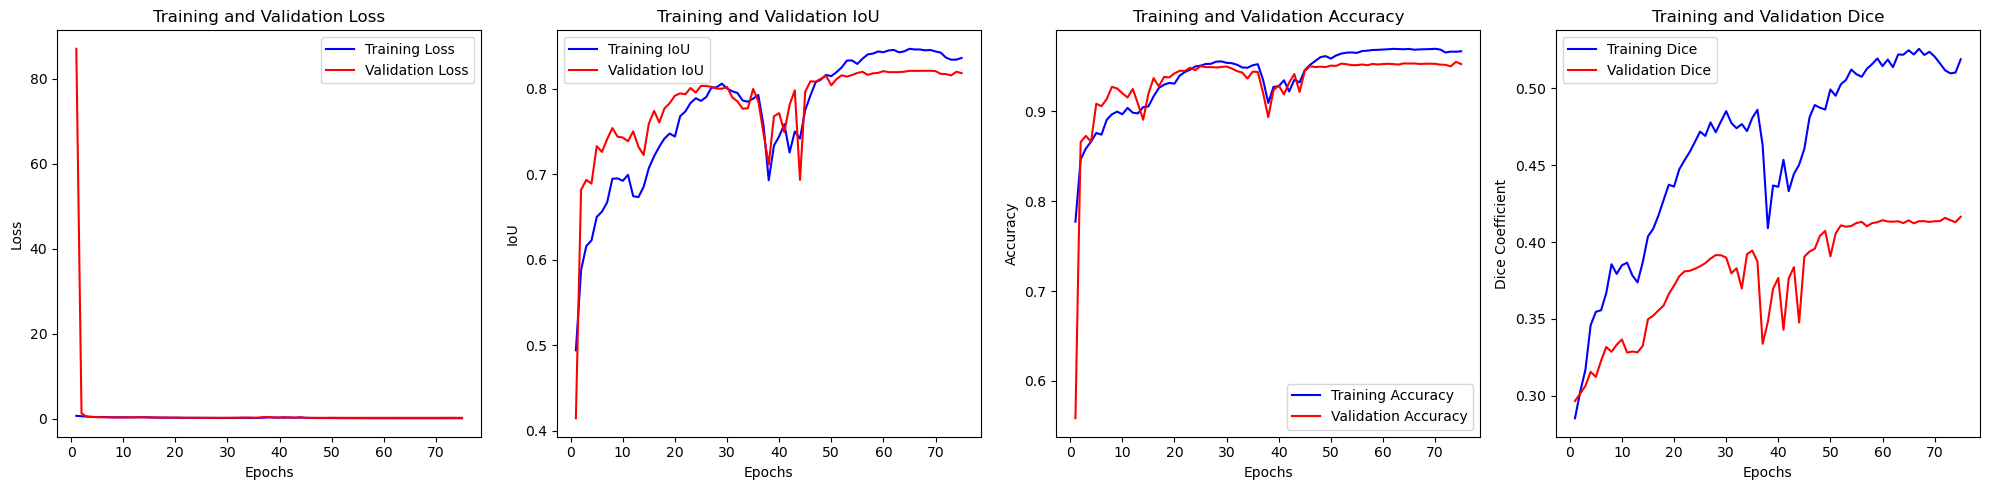

In [678]:
 # Plot training metrics
plot_metrics(train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies, train_dice, val_dice)

In [679]:
# Evaluate the model
accuracy, iou, dice, precision, recall, f1 = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}, Test IoU: {iou:.4f}, Test Dice: {dice:.4f}")
print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}")

Test Accuracy: 0.9338, Test IoU: 0.7540, Test Dice: 0.5253
Test Precision: 0.9395, Test Recall: 0.8570, Test F1 Score: 0.8964


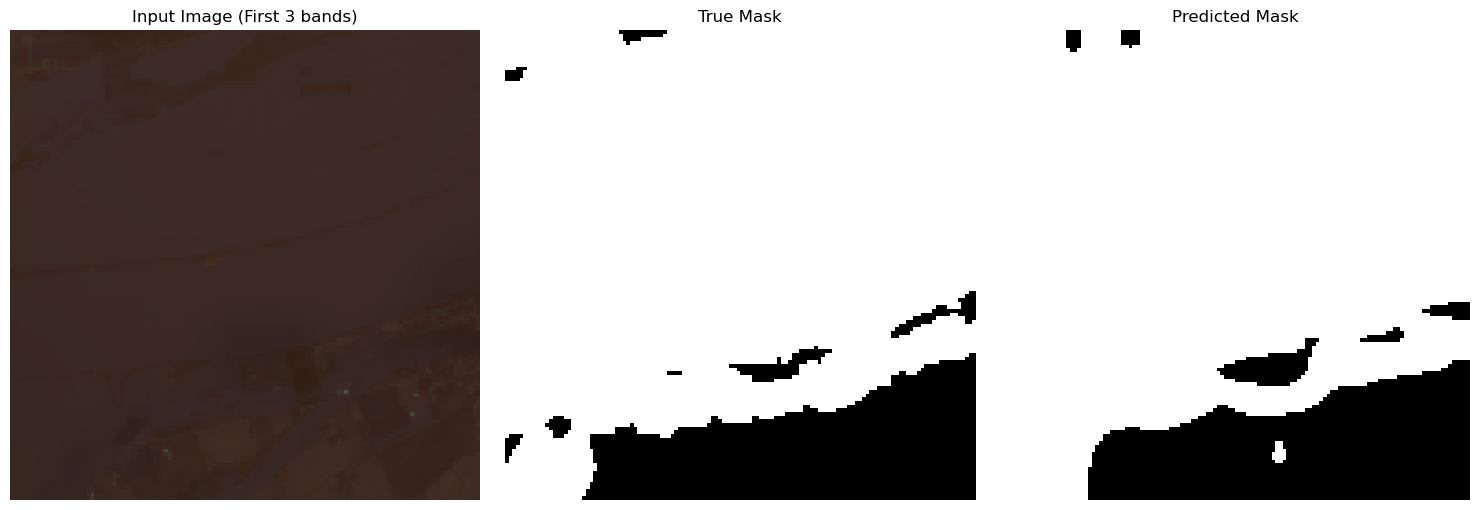

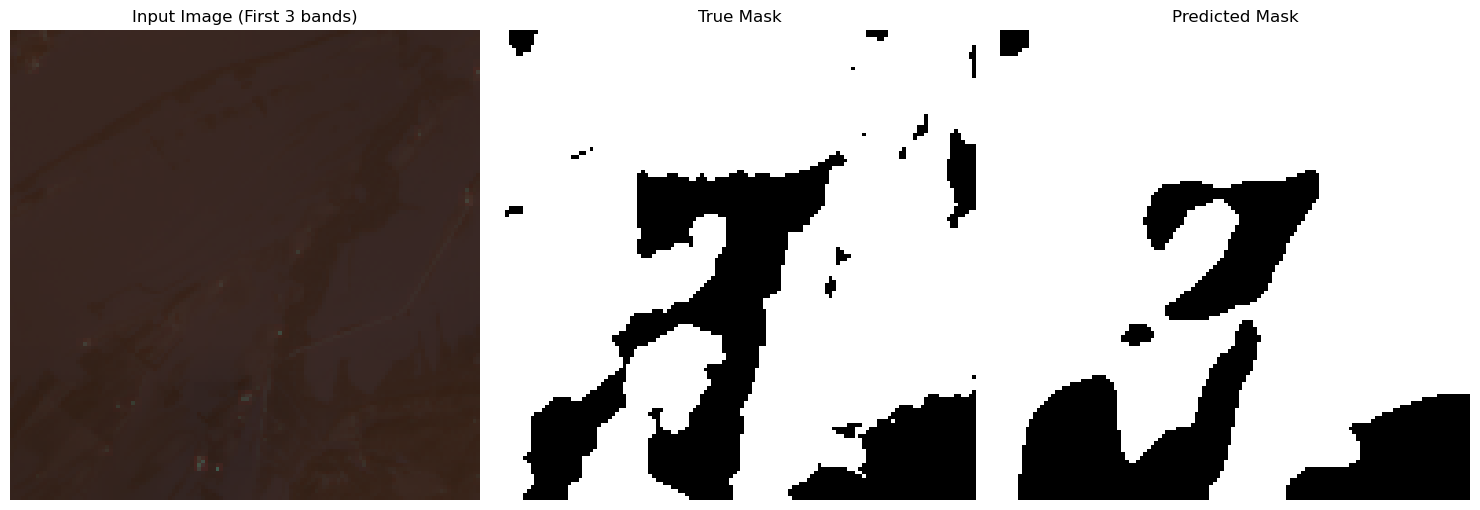

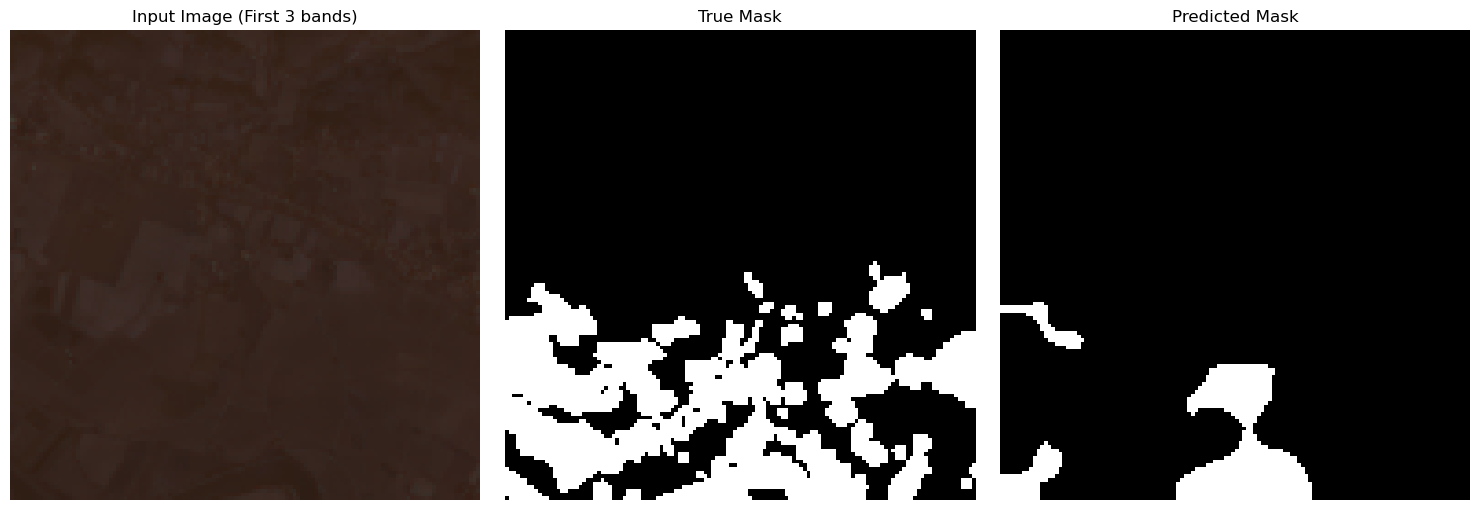

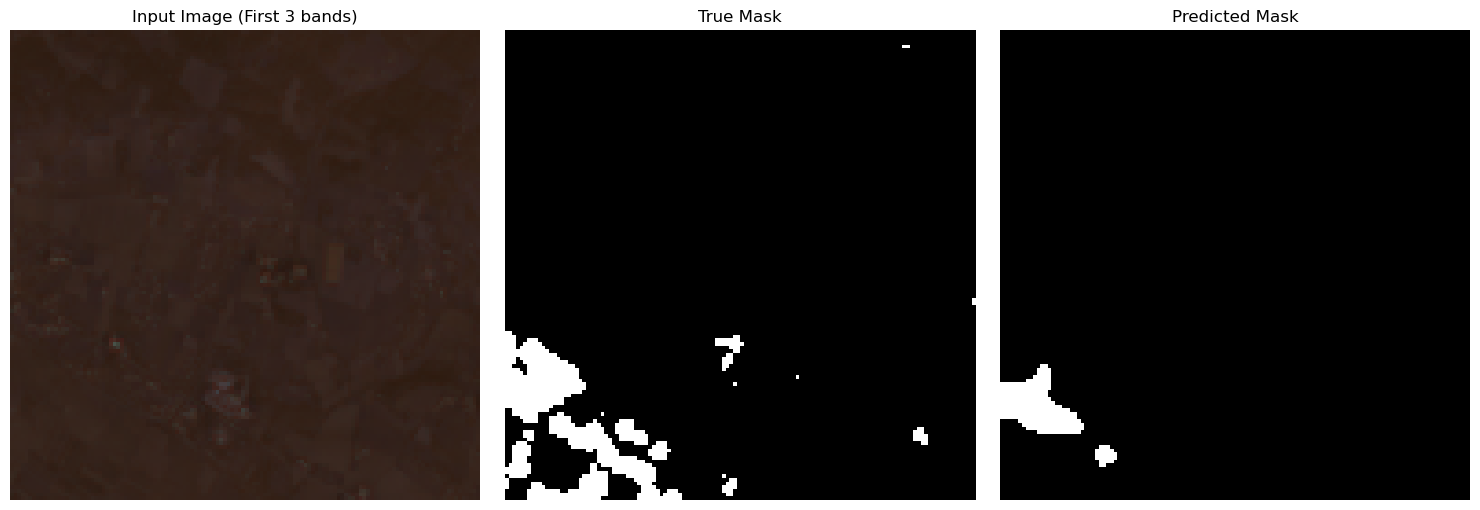

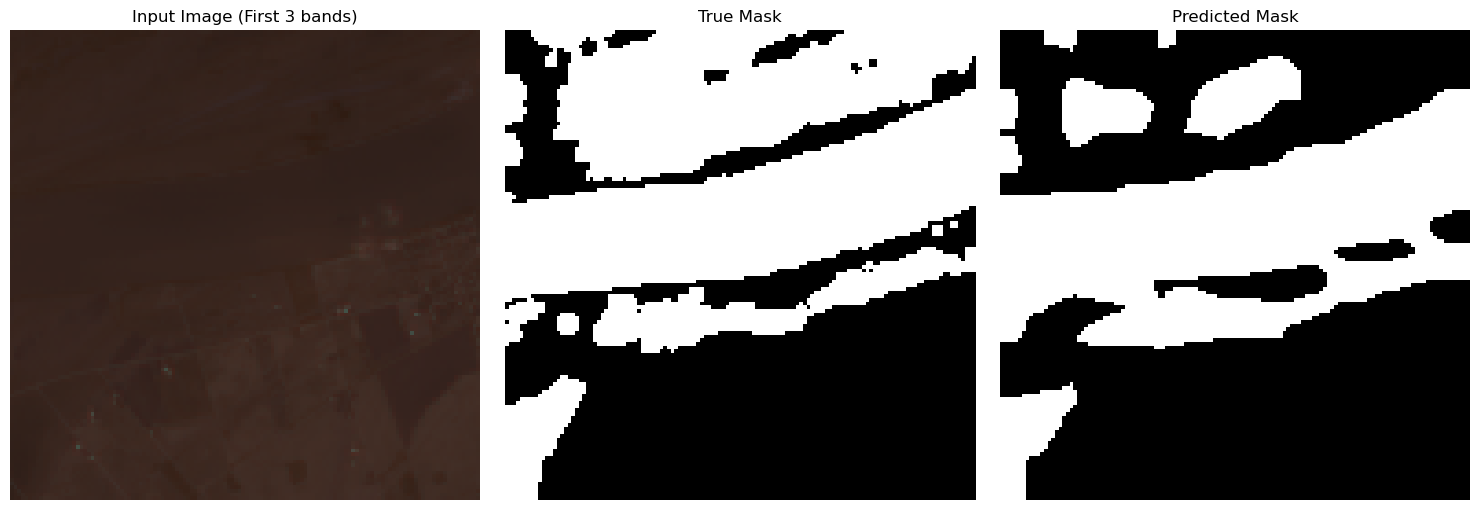

In [680]:
# Visualize predictions
visualize_predictions(model, test_dataset)

In [698]:
def calculate_iou(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) using true positives, false positives, and false negatives.

    Args:
    y_true (numpy.array): Ground truth binary array.
    y_pred (numpy.array): Predicted binary array.

    Returns:
    float: IoU score.
    """
    # Convert predictions to binary (1 or 0)
    y_pred = (y_pred > 0.5).astype(int)

    # True Positives (TP): correctly predicted positive pixels
    TP = np.logical_and(y_true == 1, y_pred == 1).sum()

    # False Positives (FP): incorrectly predicted positive pixels
    FP = np.logical_and(y_true == 0, y_pred == 1).sum()

    # False Negatives (FN): incorrectly predicted negative pixels
    FN = np.logical_and(y_true == 1, y_pred == 0).sum()

    # Calculate IoU
    denominator = TP + FP + FN
    if denominator == 0:
        return 0  # To handle cases where there are no positives in both y_true and y_pred
    IoU = TP / denominator
    return IoU

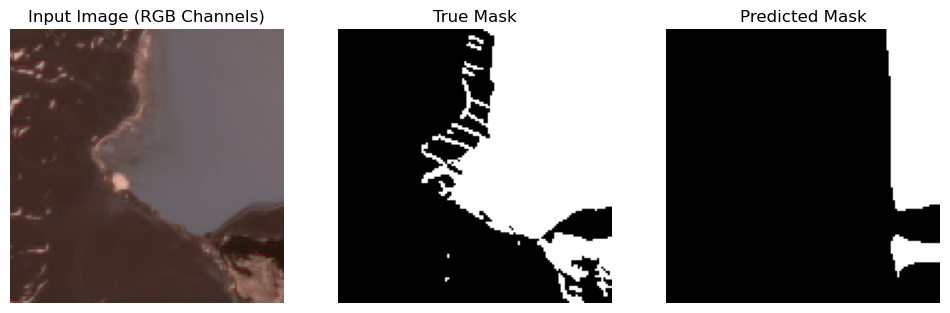

Sample 1, IoU Score: 0.33


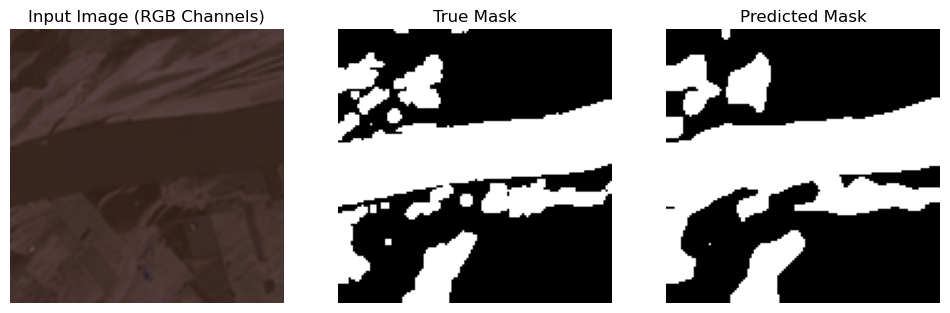

Sample 2, IoU Score: 0.85


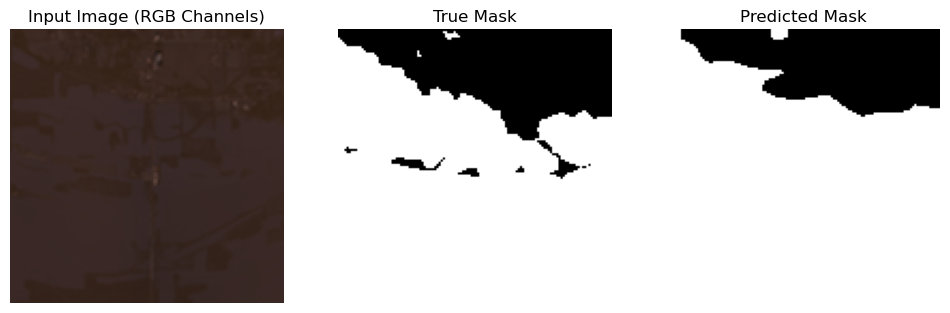

Sample 3, IoU Score: 0.93


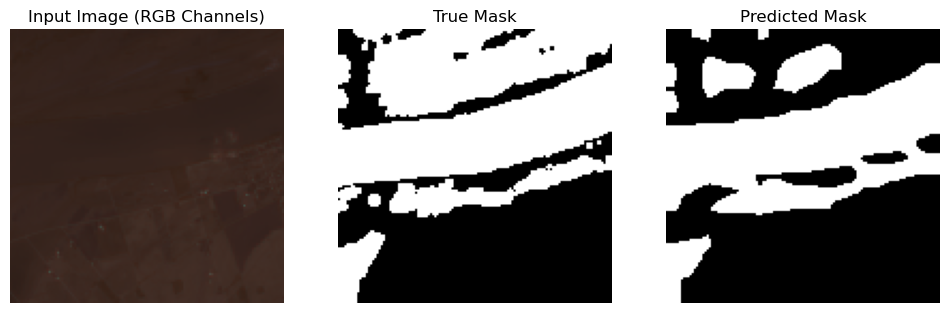

Sample 4, IoU Score: 0.66


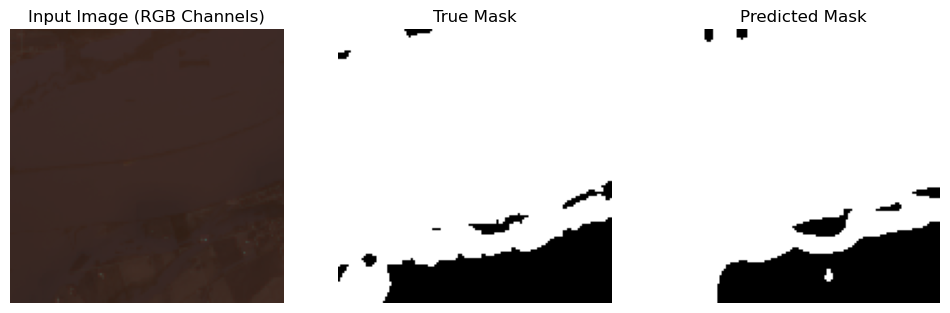

Sample 5, IoU Score: 0.96
Average IoU Score over 5 samples: 0.75


In [702]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, dataset, device, num_samples=5):
    model.eval()
    total_iou = 0.0
    num_images = min(num_samples, len(dataset))

    for i in range(num_images):
        image, mask = dataset[i]
        image = image.unsqueeze(0).to(device)
        mask = mask.numpy()  # Assuming mask is a torch tensor

        with torch.no_grad():
            output = model(image)
            pred = torch.sigmoid(output['out']).cpu().numpy() > 0.5  # Using 'out' key and thresholding

        # Flatten arrays for IoU calculation
        flat_pred = pred.flatten()
        flat_mask = mask.flatten()
        iou = calculate_iou(flat_mask, flat_pred)
        total_iou += iou

        # Visualization
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        # Select only the first three channels (RGB) for visualization
        rgb_image = np.transpose(image.squeeze().cpu().numpy()[0:3], (1, 2, 0))
        plt.imshow(rgb_image)  # Adjust if channels need to be reordered
        plt.title('Input Image (RGB Channels)')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')  # Assuming mask needs to be squeezed
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred.squeeze(), cmap='gray')  # Assuming pred needs to be squeezed
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

        print(f"Sample {i+1}, IoU Score: {iou:.2f}")

    print(f"Average IoU Score over {num_images} samples: {total_iou / num_images:.2f}")

# Call this function with your model, test dataset, and device
evaluate_and_visualize(model, test_dataset, device)